In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bnk

# Structure

## Atom Structure

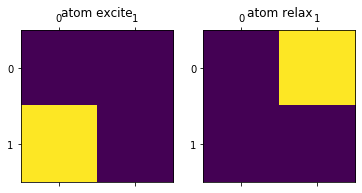

In [2]:
atom = bnk.HSpace(2, name='atom')

atom_excite = atom.eigenstate(1) @ atom.eigenstate(0).ct
atom_relax = atom_excite.ct


plt.subplot(1, 2, 1)
plt.matshow(atom_excite.flattened_values, 0)
plt.title("atom excite")

plt.subplot(1, 2, 2)
plt.matshow(atom_relax.flattened_values, 0)
plt.title("atom relax")

plt.show()

## Field Structure

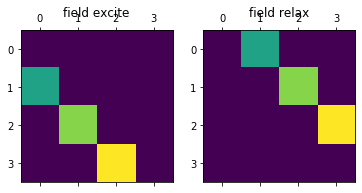

In [3]:
field = bnk.HSpace(4, name='field')

field_excite = 0
for i in range(1, field.n):
    field_excite_i = field.eigenstate(i) @ field.eigenstate(i - 1).ct
    field_excite += np.sqrt(i) * field_excite_i
field_relax = field_excite.ct


plt.subplot(1, 2, 1)
plt.matshow(field_excite.flattened_values, 0)
plt.title("field excite")

plt.subplot(1, 2, 2)
plt.matshow(field_relax.flattened_values, 0)
plt.title("field relax")

plt.show()

# Evolution

## Hamiltonian

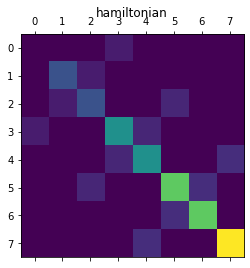

In [4]:
hb = 1
w = 1
g = 0.3

interaction = g * (
    atom_relax @ field_excite +
    atom_excite @ field_relax +
    atom_excite @ field_excite +
    atom_relax @ field_relax
)

energy = hb * w * (
    atom_excite @ atom_relax +
    field_excite @ field_relax
)

hamiltonian = energy + interaction


plt.matshow(hamiltonian.flattened_values)
plt.title("hamiltonian")
plt.show()

# Iteration

## Initial $\rho$

In [5]:
psi0 = atom.eigenstate(0) @ field.eigenstate(1)

print(psi0.flattened_values)

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## Configurations

In [6]:
dt = 1e-5
mt = 100

dlt = mt/200

## Iterations

In [7]:
%%time

_, logs_t, logs_v = bnk.evolve_schrodinger_with_logs(
    psi0,hamiltonian,hb,
    mt,dt,dlt, logger=lambda psi: np.conj(psi.values) * psi.values)

computing...100.00%
Wall time: 1min 33s


C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


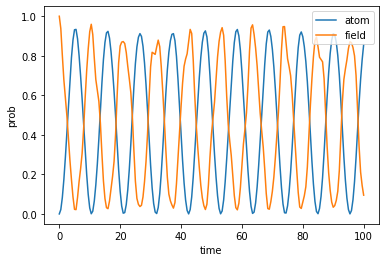

In [8]:
plt.plot(logs_t, logs_v[:,1,0], label='atom')
plt.plot(logs_t, logs_v[:,0,1], label='field')
plt.legend()
plt.xlabel("time")
plt.ylabel("prob")
plt.show()

# Iteration (Reduced)

## Initial $\rho$

In [9]:
psi0 = atom.eigenstate(0) @ field.eigenstate(1)

print(psi0.flattened_values)

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## Reduce

In [10]:
reduced_space = bnk.ReducedHSpace([psi0],[hamiltonian],'reduced_system')

for eigenstate in reduced_space.org_eigenstates:
    print(eigenstate.values)

[[0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]]


[[1.]
 [0.]
 [0.]
 [0.]]


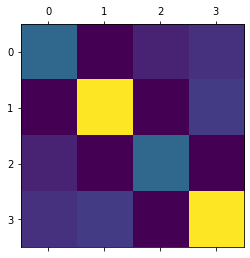

In [11]:
reduced_psi0 = reduced_space.reduce(psi0)
reduced_hamiltonian = reduced_space.reduce(hamiltonian)

print(reduced_psi0.flattened_values)
plt.matshow(reduced_hamiltonian.flattened_values)

## Configurations

In [12]:
dt = 1e-5
mt = 100

dlt = mt/200

## Iterations

In [13]:
def logger(psi:bnk.QTensor):
    psi = reduced_space.inflate(psi)
    probs = np.conj(psi.values) * psi.values
    return probs

In [14]:
%%time

_, logs_t, logs_v = bnk.evolve_schrodinger_with_logs(
    reduced_psi0, reduced_hamiltonian, hb,
    mt, dt, dlt,
    logger=logger)

computing...100.00%
Wall time: 1min 23s


C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\keli\Anaconda3\envs\sci\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


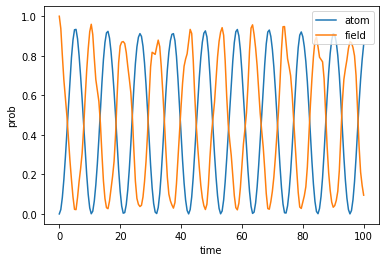

In [15]:
plt.plot(logs_t, logs_v[:,1,0], label='atom')
plt.plot(logs_t, logs_v[:,0,1], label='field')
plt.legend()
plt.xlabel("time")
plt.ylabel("prob")
plt.show()